# Joint Image & Text Embeddings

[github](https://github.com/shibing624/similarities/blob/main/examples/image_search.ipynb)|[colab](https://colab.research.google.com/github/shibing624/similarities/blob/main/examples/image_search.ipynb)|[nbviewer](https://nbviewer.jupyter.org/github/shibing624/similarities/blob/main/examples/image_search.ipynb)

This example shows how SentenceTransformer can be used to map images and texts to the same vector space. 

As model, we use the [OFA-Sys/chinese-clip-vit-huge-patch14](https://huggingface.co/OFA-Sys/chinese-clip-vit-huge-patch14), which was trained on a large set of images and image alt texts.

As a source for fotos, we use the [Unsplash Dataset Lite](https://unsplash.com/data), which contains about 25k images. See the [License](https://unsplash.com/license) about the Unsplash images. 

Note: 25k images is rather small. If you search for really specific terms, the chance are high that no such photo exist in the collection.

In [ ]:
# !pip install -U similarities

In [1]:
import sys

import pandas as pd
import glob
import json
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm import tqdm

sys.path.append('..')
from similarities import clip_embedding, clip_index, clip_filter, clip_server
from similarities.utils.get_file import http_get

<ipython-input-1-3762d28268b9>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[2023-10-07 19:54:30,942] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# Next, we get about 25k images from Unsplash 
img_folder = 'photos/'
clip_folder = 'photos/csv/'
if not os.path.exists(clip_folder) or len(os.listdir(clip_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if not exist
        http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)
    df = pd.DataFrame({'image_path': glob.glob(img_folder + '/*'), 'image_name': [os.path.basename(x) for x in glob.glob(img_folder + '/*')]})
    os.makedirs(clip_folder, exist_ok=True)
    df.to_csv(f'{clip_folder}/unsplash-25k-photos.csv', index=False)

In [3]:
# Now, we need to compute the embeddings
# Build embedding
clip_embedding(
    input_dir='photos/csv/',
    chunk_size=10000,
    image_embeddings_dir='clip_engine_25k/image_emb/',
    text_embeddings_dir=None,
    corpus_dir='clip_engine_25k/corpus/',
    model_name="OFA-Sys/chinese-clip-vit-base-patch16",
    batch_size=4,
    enable_image=True,
    image_column_name='image_path',
    enable_text=False,
    target_devices=None,
    normalize_embeddings=True,
)


Images: 24996


In [ ]:
# Build index
clip_index(
    image_embeddings_dir='clip_engine_25k/image_emb/',
    text_embeddings_dir=None,
    image_index_dir='clip_engine_25k/image_index/',
    text_index_dir=None,
    index_name='faiss.index',
    max_index_memory_usage='4G',
    current_memory_available='8G',
    use_gpu=False,
    nb_cores=None,
)


In [ ]:

# Filter(search) 文搜图, support multi query, batch search
sentences = ['老虎', 'Two dogs playing in the snow']
hits = clip_filter(
    texts=sentences,
    output_file="outputs/result_txt.json",
    model_name="OFA-Sys/chinese-clip-vit-base-patch16",
    index_dir='clip_engine_25k/image_index/',
    index_name="faiss.index",
    corpus_dir='clip_engine_25k/corpus/',
    num_results=5,
    threshold=None,
    device=None,
)


for q, sorted_text_scores in zip(sentences, hits):
    print("Query:")
    display(q)
    print("\nTop 5 most similar image in corpus:")
    # [{'item': i, 'similarity': j, 'id': k} for i, j, k in sorted_text_scores]

    for text_score in sorted_text_scores[0:5]:
        item = text_score[0]
        print(item, "(Score: %.4f)" % (text_score[1]))
        item_dict = json.loads(item)
        image_path = item_dict.get('image_path', "")
        display(IPImage(image_path), width=200)

# Image-to-Image Search
You can use the method also for image-to-image search.

To achieve this, you pass `Image.open('path/to/image.jpg')` to the search method.

It will then return similar images

Query:


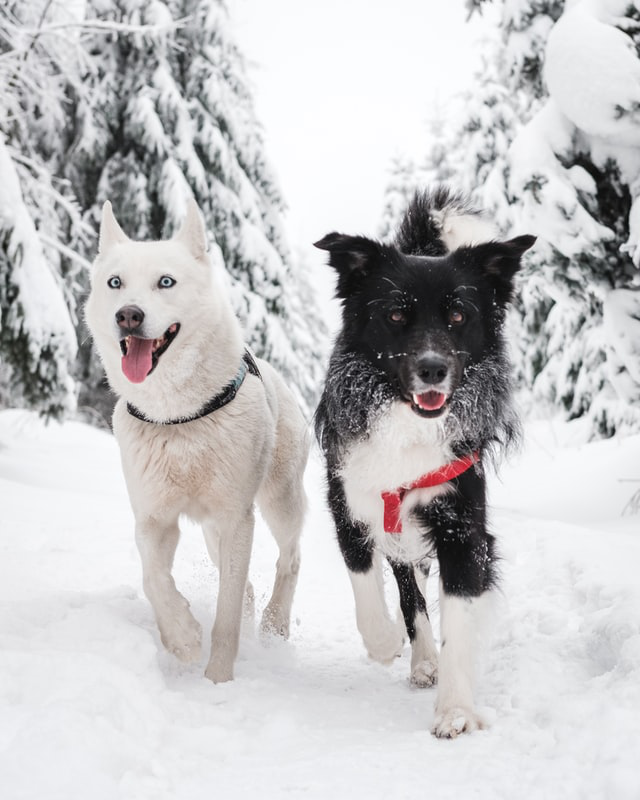

lyStEjlKNSw.jpg


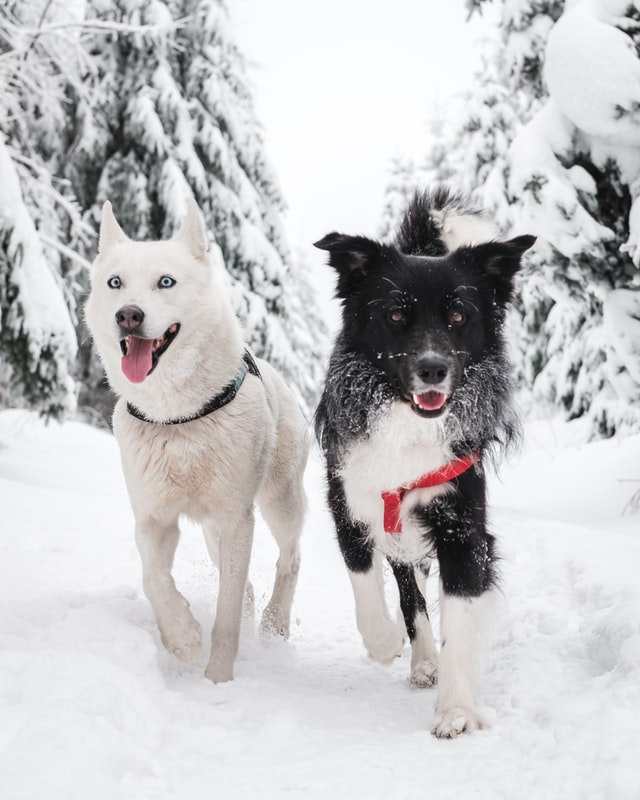

8rmYDezMIE4.jpg


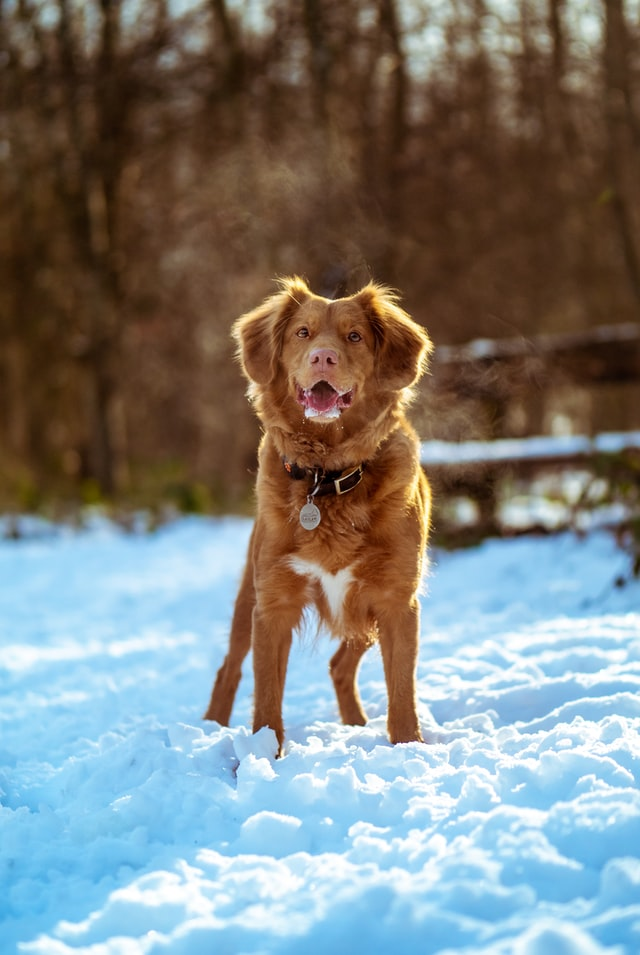

mMj5ykKvwAk.jpg


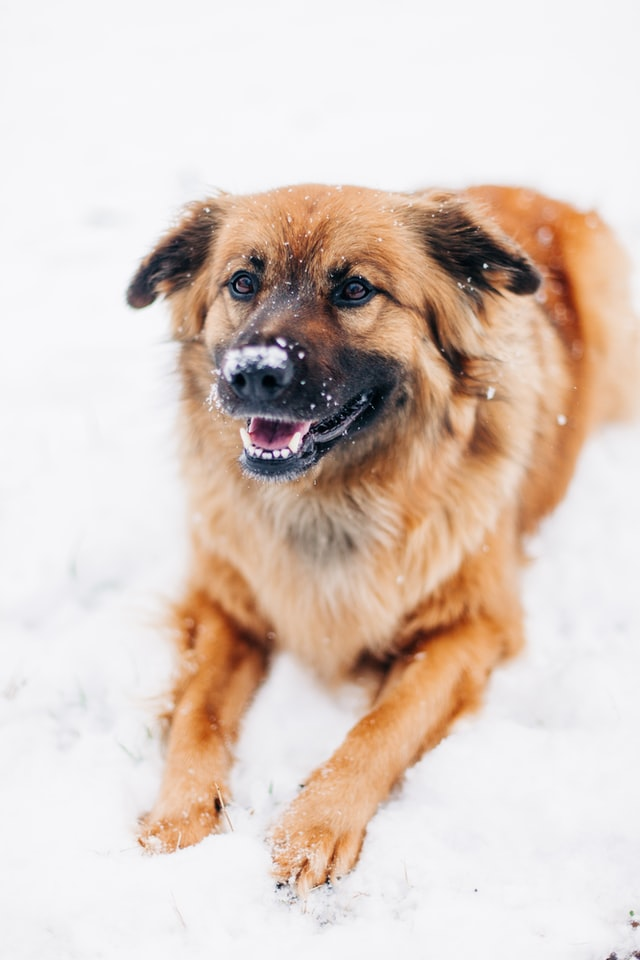

nJW1RzBXZcI.jpg


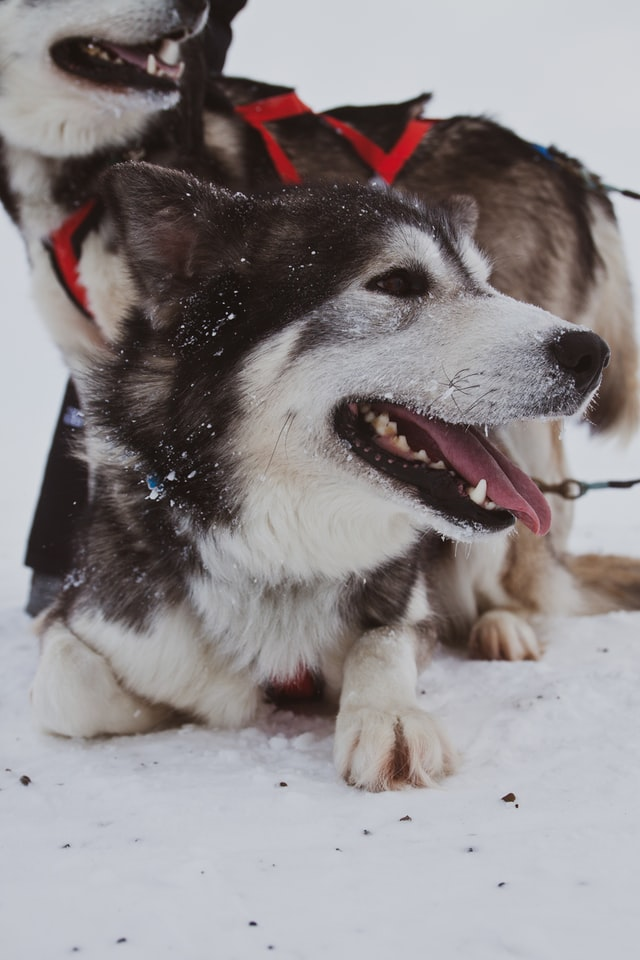

Xmo004TUzrI.jpg


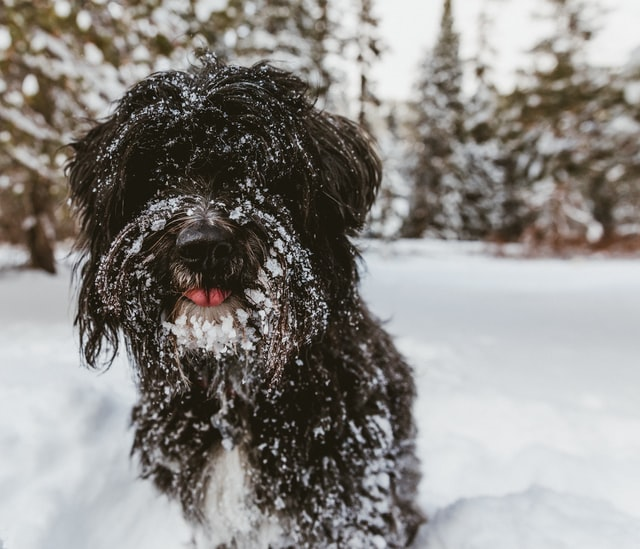

In [12]:
# Filter(search) 图搜图, support multi query, batch search
images = ['data/image1.png', 'data/image3.png']
hits = clip_filter(
    images=images,
    output_file="outputs/result_img.json",
    model_name="OFA-Sys/chinese-clip-vit-base-patch16",
    index_dir='clip_engine_25k/image_index/',
    index_name="faiss.index",
    corpus_dir='clip_engine_25k/corpus/',
    num_results=5,
    threshold=None,
    device=None,
)


for q, sorted_text_scores in zip(images, hits):
    print("Query:")
    display(q)
    print("\nTop 5 most similar image in corpus:")
    # [{'item': i, 'similarity': j, 'id': k} for i, j, k in sorted_text_scores]

    for text_score in sorted_text_scores[0:5]:
        item = text_score[0]
        print(item, "(Score: %.4f)" % (text_score[1]))
        item_dict = json.loads(item)
        image_path = item_dict.get('image_path', "")
        display(IPImage(image_path), width=200)